# AIM 

* RNN-LSTMで正弦波を予測するモデル ver. L.LSTM

In [1]:
import datetime
import numpy as np
import matplotlib.pylab as plt
from chainer import Chain, Variable, cuda, optimizer, optimizers, serializers
import chainer.functions as F
import chainer.links as L

In [2]:
from pkg_resources import get_distribution
import platform
print("python", platform.python_version())
print("")
libs = ["numpy", "chainer", "matplotlib"]
for lib in libs:
    version = get_distribution(lib).version
    print(lib, version)

python 3.5.2

numpy 1.13.1
chainer 2.0.2
matplotlib 2.0.2


In [3]:
# モデルクラス定義

class LSTM(Chain):
    def __init__(self, in_size, hidden_size, out_size):
        # クラスの初期化
        # :param in_size: 入力層のサイズ
        # :param hidden_size: 隠れ層のサイズ
        # :param out_size: 出力層のサイズ
        super(LSTM, self).__init__(
            xh = L.Linear(in_size, hidden_size),
            hh = L.LSTM(hidden_size, hidden_size),
            hy = L.Linear(hidden_size, out_size)
        )
 
    def __call__(self, x, t=None, train=False):
        # 順伝播の計算を行う関数
        # :param x: 入力値
        # :param t: 正解の予測値
        # :param train: 学習かどうか
        # :return: 計算した損失 or 予測値
        x = Variable(x)
        if train:
            t = Variable(t)
        h = self.xh(x)
        h = self.hh(h)
        y = self.hy(h)
        if train:
            return F.mean_squared_error(y, t)
        else:
            return y.data
 
    def reset(self):
        # 勾配の初期化とメモリの初期化
        self.zerograds()
        self.hh.reset_state()

In [4]:
# 学習

EPOCH_NUM = 1000
HIDDEN_SIZE = 5
BATCH_ROW_SIZE = 100 # 分割した時系列をいくつミニバッチに取り込むか
BATCH_COL_SIZE = 100 # ミニバッチで分割する時系列数
 
# 教師データ
train_data = np.array([np.sin(i*2*np.pi/50) for i in range(50)]*10)
 
# 教師データを変換
train_x, train_t = [], []
for i in range(len(train_data)-1):
    train_x.append(train_data[i])
    train_t.append(train_data[i+1])
train_x = np.array(train_x, dtype="float32")
train_t = np.array(train_t, dtype="float32")
in_size = 1
out_size = 1
N = len(train_x)
 
# モデルの定義
model = LSTM(in_size=in_size, hidden_size=HIDDEN_SIZE, out_size=out_size)
optimizer = optimizers.Adam()
optimizer.setup(model)
    
# 学習開始
print("Train")
st = datetime.datetime.now()
for epoch in range(EPOCH_NUM):

    # ミニバッチ学習
    x, t = [], []
    #  ミニバッチ学習データとして、時系列全体から、BATCH_COL_SIZE分の時系列を抜き出したものを、BATCH_ROW_SIZE個用意する
    for i in range(BATCH_ROW_SIZE):
        index = np.random.randint(0, N-BATCH_COL_SIZE+1) # ランダムな箇所、ただしBATCH_COL_SIZE分だけ抜き取れる場所から選ぶ
        x.append(train_x[index:index+BATCH_COL_SIZE]) # BATCH_COL_SIZE分の時系列を取り出す
        t.append(train_t[index:index+BATCH_COL_SIZE])
    x = np.array(x, dtype="float32")
    t = np.array(t, dtype="float32")
    loss = 0
    total_loss = 0
    model.reset() # 勾配とメモリの初期化
    for i in range(BATCH_COL_SIZE): # 各時刻おきにBATCH_ROW_SIZEごと読み込んで損失を計算する
        x_ = np.array([x[j, i] for j in range(BATCH_ROW_SIZE)], dtype="float32")[:, np.newaxis] # 時刻iの入力値
        t_ = np.array([t[j, i] for j in range(BATCH_ROW_SIZE)], dtype="float32")[:, np.newaxis] # 時刻i+1の値（＝正解の予測値）
        loss += model(x=x_, t=t_, train=True)
    loss.backward()
    loss.unchain_backward()
    total_loss += loss.data
    optimizer.update()
    if (epoch+1) % 100 == 0:
        ed = datetime.datetime.now()
        print("epoch:\t{}\ttotal loss:\t{}\ttime:\t{}".format(epoch+1, total_loss, ed-st))
        st = datetime.datetime.now()

Train
epoch:	100	total loss:	12.645332336425781	time:	0:00:12.869294
epoch:	200	total loss:	5.172049045562744	time:	0:00:14.587597
epoch:	300	total loss:	2.2730612754821777	time:	0:00:13.370348
epoch:	400	total loss:	1.561941146850586	time:	0:00:12.707068
epoch:	500	total loss:	1.0845425128936768	time:	0:00:13.459392
epoch:	600	total loss:	0.7788888812065125	time:	0:00:16.692302
epoch:	700	total loss:	0.6147133111953735	time:	0:00:12.526217
epoch:	800	total loss:	0.4324166476726532	time:	0:00:13.348142
epoch:	900	total loss:	0.35354918241500854	time:	0:00:13.969820
epoch:	1000	total loss:	0.29492804408073425	time:	0:00:17.687523



Predict


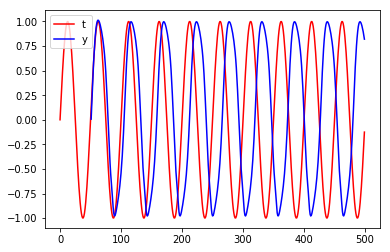

In [5]:
# 予測

print("Predict")
predict = np.empty(0) # 予測時系列
inseq_size = 50
inseq = train_data[:inseq_size] # 予測直前までの時系列
for _ in range(N - inseq_size):
    model.reset() # メモリを初期化
    for i in inseq: # モデルに予測直前までの時系列を読み込ませる
        x = np.array([[i]], dtype="float32")
        y = model(x=x, train=False)
    predict = np.append(predict, y) # 最後の予測値を記録
    # モデルに読み込ませる予測直前時系列を予測値で更新する
    inseq = np.delete(inseq, 0)
    inseq = np.append(inseq, y)

plt.plot(range(N+1), train_data, color="red", label="t")
plt.plot(range(inseq_size+1, N+1), predict, color="blue", label="y")
plt.legend(loc="upper left")
plt.show()